In [200]:
 # - Network 256 512 512 96
 # - EPOCHS = 170
 # - BATCH_SIZE = 8
 # - LEARNING_RATE = 0.001
 # - DROPOUT = 0.06

In [201]:
import pandas as pd
import pickle
from google.cloud import storage
from google.cloud import bigquery
from google.cloud import aiplatform
from google.cloud import aiplatform_v1beta1
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import matplotlib.pyplot as plt 

In [202]:
aiplatform.init(location='asia-northeast3')

In [203]:
def download_blob(bucket_name, source_blob_name, destination_file_name):
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)


In [204]:
download_blob("mlops-test-kay", "airport_passenger/X_val_multi_scaled_nm_ns_7_lt21_tr_fm.pkl", "X_val_multi_scaled_nm_ns_7_lt21_tr_fm.pkl")

In [205]:
with open('X_val_multi_scaled_nm_ns_7_lt21_tr_fm.pkl','rb') as f:
    X_val_multi_scaled = pickle.load(f)

In [206]:
X_val_multi_scaled_list=X_val_multi_scaled.tolist()

In [207]:
aiplatform.init(project='charged-genre-350106', location='asia-northeast3')

endpoint = aiplatform.Endpoint('5309286563832659968')

prediction = endpoint.predict(instances=X_val_multi_scaled_list)
print(prediction)

Prediction(predictions=[[0.778346837, 0.668806255, 0.704734266, 0.800670385, 0.667222619, 0.851956129, 0.774886608], [0.708459139, 0.703268528, 0.745127618, 0.748522043, 0.855379343, 0.690390468, 0.80894649], [0.744470596, 0.812962, 0.66747725, 0.829734325, 0.784788, 0.662097335, 0.738003969], [0.81129241, 0.695138097, 0.794436038, 0.814004898, 0.675378382, 0.682535768, 0.721988678], [0.675900638, 0.799737096, 0.760173678, 0.750034809, 0.68997407, 0.583176792, 0.752378345], [0.864033878, 0.759924054, 0.599974394, 0.700170636, 0.575061321, 0.732531786, 0.62405467], [0.838658333, 0.651087046, 0.631827235, 0.685669184, 0.60227555, 0.722188354, 0.723233223], [0.752007961, 0.642568946, 0.675904334, 0.652232766, 0.737346709, 0.653468728, 0.736520827], [0.693556309, 0.675063133, 0.640951753, 0.730981171, 0.713855624, 0.615047216, 0.660384536], [0.715365529, 0.678478837, 0.683030248, 0.778874516, 0.61092484, 0.654301763, 0.657923818], [0.651142836, 0.667450488, 0.813416958, 0.666375756, 0.5872

## Inverse scaling을 위해 빅쿼리에 있는 tr, ts데이터로 scaling, inverse sclaing

In [208]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Data manipulation, visualization and useful functions
import argparse
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing

# gcp functions
from google.cloud import bigquery
from google.cloud import storage
import time
from datetime import datetime, timedelta
import pickle

n_steps=7

# Set up BigQuery & Storage clients
bqclient = bigquery.Client(project='charged-genre-350106')
storage_client = storage.Client(project='charged-genre-350106')

# Query for base dataset
query_tr = """
    SELECT *
    FROM `charged-genre-350106.demand_forecasting.airport_passenger_tr_nm_ns_7_lt21_tr`
    """

query_vd = """
    SELECT *
    FROM `charged-genre-350106.demand_forecasting.airport_passenger_ts_nm_ns_7_lt21_tr`
    """

trds = bqclient.query(query_tr).to_dataframe()
tsds = bqclient.query(query_vd).to_dataframe()
trds=trds.sort_values(by='datetime')
tsds=tsds.sort_values(by='datetime')

def datasplit_X_Y(data, Y_colname, X_colname):
    X_colname = [x for x in data.columns if x not in Y_colname + X_remove]
    Y_data = data[Y_colname]
    X_data = data[X_colname]
    print('X:', X_data.shape, 'Y:', Y_data.shape)
    return X_data, Y_data

# Data Split to X and Y
Y_colname = ['count']
X_remove = ['datetime', 'data_split']
X_colname = [x for x in trds.columns if x not in Y_colname]# + X_remove]
X_train, Y_train = datasplit_X_Y(trds, Y_colname, X_colname)
X_val, Y_val = datasplit_X_Y(tsds, Y_colname, X_colname)

continous_feature=[
'ticket_1', 'ticket_2', 'ticket_3','ticket_4','ticket_5','ticket_6','ticket_7',
                    'ticket_8', 'ticket_9', 'ticket_10','ticket_11','ticket_12','ticket_13','ticket_14',
                    'ticket_15','ticket_16', 'ticket_17','ticket_18','ticket_19','ticket_20','ticket_21',
                    'fare_min_1','fare_min_2','fare_min_3','fare_min_4','fare_min_5','fare_min_6','fare_min_7',
                    'fare_min_8','fare_min_9','fare_min_10','fare_min_11','fare_min_12','fare_min_13','fare_min_14',
                    'fare_min_15','fare_min_16','fare_min_17','fare_min_18','fare_min_19','fare_min_20','fare_min_21', 
                    'fare_max_1','fare_max_2','fare_max_3','fare_max_4','fare_max_5','fare_max_6','fare_max_7',
                    'fare_max_8','fare_max_9','fare_max_10','fare_max_11','fare_max_12','fare_max_13','fare_max_14',
                    'fare_max_15','fare_max_16','fare_max_17','fare_max_18','fare_max_19','fare_max_20','fare_max_21',
                    'fare_avg_1','fare_avg_2','fare_avg_3','fare_avg_4','fare_avg_5','fare_avg_6','fare_avg_7',
                    'fare_avg_8','fare_avg_9','fare_avg_10','fare_avg_11','fare_avg_12','fare_avg_13','fare_avg_14',
                    'fare_avg_15','fare_avg_16','fare_avg_17','fare_avg_18','fare_avg_19','fare_avg_20','fare_avg_21',
                    'fare_std_1','fare_std_2','fare_std_3','fare_std_4','fare_std_5','fare_std_6','fare_std_7',
                    'fare_std_8','fare_std_9','fare_std_10','fare_std_11','fare_std_12','fare_std_13','fare_std_14',
                    'fare_std_15','fare_std_16','fare_std_17','fare_std_18','fare_std_19','fare_std_20','fare_std_21',
                    'seat_min_1','seat_min_2','seat_min_3','seat_min_4','seat_min_5','seat_min_6','seat_min_7',
                    'seat_min_8','seat_min_9','seat_min_10','seat_min_11','seat_min_12','seat_min_13','seat_min_14',
                    'seat_min_15','seat_min_16','seat_min_17','seat_min_18','seat_min_19','seat_min_20','seat_min_21',
                    'seat_max_1','seat_max_2','seat_max_3','seat_max_4','seat_max_5','seat_max_6','seat_max_7',
                    'seat_max_8','seat_max_9','seat_max_10','seat_max_11','seat_max_12','seat_max_13','seat_max_14',
                    'seat_max_15','seat_max_16','seat_max_17','seat_max_18','seat_max_19','seat_max_20','seat_max_21',
                    'seat_avg_1','seat_avg_2','seat_avg_3','seat_avg_4','seat_avg_5','seat_avg_6','seat_avg_7',
                    'seat_avg_8','seat_avg_9','seat_avg_10','seat_avg_11','seat_avg_12','seat_avg_13','seat_avg_14',
                    'seat_avg_15','seat_avg_16','seat_avg_17','seat_avg_18','seat_avg_19','seat_avg_20','seat_avg_21',
                    'seat_std_1','seat_std_2','seat_std_3','seat_std_4','seat_std_5','seat_std_6','seat_std_7',
                    'seat_std_8','seat_std_9','seat_std_10','seat_std_11','seat_std_12','seat_std_13','seat_std_14',
                    'seat_std_15','seat_std_16','seat_std_17','seat_std_18','seat_std_19','seat_std_20','seat_std_21',
                    'b_1','b_2','b_3','b_4','b_5','b_6','b_7','b_8','b_9','b_10','b_11','b_12','b_13','b_14','b_15','b_16','b_17','b_18','b_19','b_20','b_21',
                    'f_1','f_2','f_3','f_4','f_5','f_6','f_7','f_8','f_9','f_10','f_11','f_12','f_13','f_14','f_15','f_16','f_17','f_18','f_19','f_20','f_21',
                    'd_1','d_2','d_3','d_4','d_5','d_6','d_7','d_8','d_9','d_10','d_11','d_12','d_13','d_14','d_15','d_16','d_17','d_18','d_19','d_20','d_21',
                    's_1','s_2','s_3','s_4','s_5','s_6','s_7','s_8','s_9','s_10','s_11','s_12','s_13','s_14','s_15','s_16','s_17','s_18','s_19','s_20','s_21',
                    'sd_1','sd_2','sd_3','sd_4','sd_5','sd_6','sd_7','sd_8','sd_9','sd_10','sd_11','sd_12','sd_13','sd_14','sd_15','sd_16','sd_17','sd_18','sd_19','sd_20','sd_21',
                      'lt_1',   'lt_2',   'lt_3',   'lt_4',   'lt_5',   'lt_6' , 'lt_7', 
                      'lt_8',   'lt_9',   'lt_10',  'lt_11',  'lt_12',  'lt_13', 'lt_14',
                      'lt_15',   'lt_16',   'lt_17',  'lt_18',  'lt_19',  'lt_20', 'lt_21',
                      'f330_1',   'f330_2',   'f330_3',   'f330_4',   'f330_5',   'f330_6' , 'f330_7',  
                      'f330_8',   'f330_9',   'f330_10',  'f330_11',  'f330_12',  'f330_13', 'f330_14',
                      'f330_15',  'f330_16',  'f330_17',  'f330_18',  'f330_19',  'f330_20', 'f330_21',
                      'f737_1',   'f737_2',   'f737_3',   'f737_4',   'f737_5',   'f737_6' , 'f737_7',  
                      'f737_8',   'f737_9',   'f737_10',  'f737_11',  'f737_12',  'f737_13', 'f737_14',
                      'f737_15',  'f737_16',  'f737_17',  'f737_18',  'f737_19',  'f737_20', 'f737_21',
                      'group_1',   'group_2',   'group_3',   'group_4',   'group_5',   'group_6' , 'group_7',  
                      'group_8',   'group_9',   'group_10',  'group_11',  'group_12',  'group_13', 'group_14',
                      'group_15',   'group_16',   'group_17',  'group_18',  'group_19',  'group_20', 'group_21',
                      'total_1',   'total_2',   'total_3',   'total_4',   'total_5',   'total_6' , 'total_7',  
                      'total_8',   'total_9',   'total_10',  'total_11',  'total_12',  'total_13', 'total_14',
                      'total_15',   'total_16',   'total_17',  'total_18',  'total_19',  'total_20', 'total_21',
                      'count_lag7','count_lag8','count_lag9','count_lag10','count_lag11','count_lag12','count_lag13'
]

category_feature=[
'holiday', 'long_h', 'b_long_h', 'inter_h', 'b_inter_h','first_m','b_first_m',
'dayofweek_dummy_0','dayofweek_dummy_1','dayofweek_dummy_2','dayofweek_dummy_3','dayofweek_dummy_4','dayofweek_dummy_5','dayofweek_dummy_6']

scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()

def scaling(x_train, y_train, x_val, y_val, scaler_X_tr=scaler_X_tr,scaler_Y_tr=scaler_Y_tr):
    
    ## Scaling
    X_train_con = scaler_X_tr.fit_transform(x_train[continous_feature])
    X_train_cat = x_train[category_feature].to_numpy()
    X_train_scaled = np.concatenate((X_train_con, X_train_cat), axis=1)
    Y_train_scaled = scaler_Y_tr.fit_transform(y_train)

    X_val_con = scaler_X_tr.transform(x_val[continous_feature])
    X_val_cat = x_val[category_feature].to_numpy()
    X_val_scaled = np.concatenate((X_val_con, X_val_cat), axis=1)
    Y_val_scaled = scaler_Y_tr.transform(y_val)
    
    print('X_train_scaled:', X_train_scaled.shape, 'Y_train_gru:', Y_train_scaled.shape)
    print('X_val_scaled:', X_val_scaled.shape, 'Y_val_gru:', Y_val_scaled.shape)
    
    return X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled

def inverse_scaling(data, scaler_Y_tr=scaler_Y_tr):
    data_scaled = np.empty([data.shape[1], data.shape[0]])
    for i in range(data.shape[1]):
        data_scaled[i] = scaler_Y_tr.inverse_transform([data[:,i]])
    return data_scaled.transpose()

X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled = scaling(X_train, Y_train, X_val, Y_val)

X: (183, 420) Y: (183, 1)
X: (21, 420) Y: (21, 1)
X_train_scaled: (183, 420) Y_train_gru: (183, 1)
X_val_scaled: (21, 420) Y_val_gru: (21, 1)


In [209]:
list(X_train.columns)

['holiday',
 'long_h',
 'b_long_h',
 'inter_h',
 'b_inter_h',
 'first_m',
 'b_first_m',
 'ticket_1',
 'ticket_2',
 'ticket_3',
 'ticket_4',
 'ticket_5',
 'ticket_6',
 'ticket_7',
 'ticket_8',
 'ticket_9',
 'ticket_10',
 'ticket_11',
 'ticket_12',
 'ticket_13',
 'ticket_14',
 'ticket_15',
 'ticket_16',
 'ticket_17',
 'ticket_18',
 'ticket_19',
 'ticket_20',
 'ticket_21',
 'fare_min_1',
 'fare_min_2',
 'fare_min_3',
 'fare_min_4',
 'fare_min_5',
 'fare_min_6',
 'fare_min_7',
 'fare_min_8',
 'fare_min_9',
 'fare_min_10',
 'fare_min_11',
 'fare_min_12',
 'fare_min_13',
 'fare_min_14',
 'fare_min_15',
 'fare_min_16',
 'fare_min_17',
 'fare_min_18',
 'fare_min_19',
 'fare_min_20',
 'fare_min_21',
 'fare_max_1',
 'fare_max_2',
 'fare_max_3',
 'fare_max_4',
 'fare_max_5',
 'fare_max_6',
 'fare_max_7',
 'fare_max_8',
 'fare_max_9',
 'fare_max_10',
 'fare_max_11',
 'fare_max_12',
 'fare_max_13',
 'fare_max_14',
 'fare_max_15',
 'fare_max_16',
 'fare_max_17',
 'fare_max_18',
 'fare_max_19',
 'far

In [210]:
X_train_scaled

array([[0.01634696, 0.04024662, 0.07249712, ..., 0.        , 0.        ,
        0.        ],
       [0.02368641, 0.04692584, 0.10471807, ..., 0.        , 0.        ,
        0.        ],
       [0.13878232, 0.04761089, 0.11622555, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.06672227, 0.09761946, 0.46490219, ..., 0.        , 0.        ,
        0.        ],
       [0.06572143, 0.09522178, 0.44303797, ..., 0.        , 0.        ,
        0.        ],
       [0.0470392 , 0.08015071, 0.33601841, ..., 0.        , 0.        ,
        0.        ]])

In [211]:
def multi_input(x_test_scaled):
    ## X / Y Split for test
    X_test_multi_scaled = []
    for index in range(n_steps, len(x_test_scaled)+1):
        # find the end of this pattern
        end_ix = index 
        out_end_ix = end_ix -1
        # check if we are beyoind the dataset
        if out_end_ix > len(x_test_scaled):
            break
        # gather input and output part of the pattern
        seq_x= x_test_scaled[index - n_steps : index, :]
        X_test_multi_scaled.append(seq_x)
    X_test_multi_scaled = np.array(X_test_multi_scaled)
    print('Predict_multi_scaled:', X_test_multi_scaled.shape)
    return X_test_multi_scaled

In [212]:
def multi_input(x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled):
    ## X / Y Split for train
    X_train_multi_scaled, Y_train_multi_scaled = [], []
    for index in range(n_steps, len(x_train_scaled)+1):
        # find the end of this pattern
        end_ix = index 
        out_end_ix = end_ix -1
        # check if we are beyoind the dataset
        if out_end_ix > len(x_train_scaled):
            break
        # gather input and output part of the pattern
        seq_x, seq_y = x_train_scaled[index - n_steps: index, :], y_train_scaled[index - n_steps: index, -1]
        X_train_multi_scaled.append(seq_x)
        Y_train_multi_scaled.append(seq_y)
    X_train_multi_scaled, Y_train_multi_scaled = np.array(X_train_multi_scaled), np.array(Y_train_multi_scaled) 
    print('X_train_multi_scaled:', X_train_multi_scaled.shape, 'Y_train_multi_scaled:', Y_train_multi_scaled.shape)
    ## X / Y Split for val
    X_val_multi_scaled, Y_val_multi_scaled = [], []
    for index in range(n_steps, len(x_val_scaled)+1):
        # find the end of this pattern
        end_ix = index 
        out_end_ix = end_ix -1
        # check if we are beyoind the dataset
        if out_end_ix > len(x_val_scaled):
            break
        # gather input and output part of the pattern
        seq_x, seq_y = x_val_scaled[index - n_steps : index, :], y_val_scaled[index - n_steps : index, -1]
        X_val_multi_scaled.append(seq_x)
        Y_val_multi_scaled.append(seq_y)
    X_val_multi_scaled, Y_val_multi_scaled = np.array(X_val_multi_scaled), np.array(Y_val_multi_scaled) 
    print('X_val_multi_scaled:', X_val_multi_scaled.shape, 'Y_val_multi_scaled:', Y_val_multi_scaled.shape)
    
    return X_train_multi_scaled, Y_train_multi_scaled, X_val_multi_scaled, Y_val_multi_scaled

In [213]:
np.shape(X_val_scaled)

(21, 420)

In [214]:
X_train_multi_scaled, Y_train_multi_scaled, X_val_multi_scaled, Y_val_multi_scaled = multi_input(X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled)

X_train_multi_scaled: (177, 7, 420) Y_train_multi_scaled: (177, 7)
X_val_multi_scaled: (15, 7, 420) Y_val_multi_scaled: (15, 7)


In [215]:
raw_predictions_0=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[0]

In [216]:

predicted_values_0=inverse_scaling(np.array([raw_predictions_0])).round().tolist()

In [217]:
predicted_values_0

[[42798.0, 39390.0, 41033.0, 43019.0, 36858.0, 41733.0, 39670.0]]

In [218]:
raw_predictions_1=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[1]
predicted_values_1=inverse_scaling(np.array([raw_predictions_1])).round().tolist()

In [219]:
predicted_values_1

[[40720.0, 39710.0, 41264.0, 39100.0, 41238.0, 38388.0, 44505.0]]

In [220]:
raw_predictions_2=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[2]
predicted_values_2=inverse_scaling(np.array([raw_predictions_2])).round().tolist()
predicted_values_2

[[41539.0, 42447.0, 38084.0, 40652.0, 41121.0, 41008.0, 44422.0]]

In [221]:
raw_predictions_3=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[3]
predicted_values_3=inverse_scaling(np.array([raw_predictions_3])).round().tolist()
predicted_values_3

[[43064.0, 39415.0, 38744.0, 42749.0, 41595.0, 43794.0, 43854.0]]

In [222]:
raw_predictions_4=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[4]
predicted_values_4=inverse_scaling(np.array([raw_predictions_4])).round().tolist()
predicted_values_4

[[39674.0, 38584.0, 42280.0, 42713.0, 44625.0, 41277.0, 44253.0]]

In [223]:
raw_predictions_5=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[5]
predicted_values_5=inverse_scaling(np.array([raw_predictions_5])).round().tolist()
predicted_values_5

[[37530.0, 42489.0, 41907.0, 44087.0, 43065.0, 41174.0, 40877.0]]

In [224]:
raw_predictions_6=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[6]
predicted_values_6=inverse_scaling(np.array([raw_predictions_6])).round().tolist()
predicted_values_6

[[42231.0, 42280.0, 44169.0, 43042.0, 41971.0, 40130.0, 40037.0]]

In [225]:
raw_predictions_7=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[7]
predicted_values_7=inverse_scaling(np.array([raw_predictions_7])).round().tolist()
predicted_values_7

[[43377.0, 43470.0, 42598.0, 41554.0, 39925.0, 39947.0, 40484.0]]

In [226]:
raw_predictions_8=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[8]
predicted_values_8=inverse_scaling(np.array([raw_predictions_8])).round().tolist()
predicted_values_8

[[45519.0, 43565.0, 40621.0, 42627.0, 35493.0, 41960.0, 37773.0]]

In [227]:
raw_predictions_9=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[9]
predicted_values_9=inverse_scaling(np.array([raw_predictions_9])).round().tolist()
predicted_values_9

[[44653.0, 41981.0, 37840.0, 40433.0, 37072.0, 41340.0, 38523.0]]

In [228]:
raw_predictions_10=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[10]
predicted_values_10=inverse_scaling(np.array([raw_predictions_10])).round().tolist()
predicted_values_10

[[43422.0, 39199.0, 38593.0, 39844.0, 38091.0, 40052.0, 39132.0]]

In [229]:
raw_predictions_11=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[11]
predicted_values_11=inverse_scaling(np.array([raw_predictions_11])).round().tolist()
predicted_values_11

[[41074.0, 38711.0, 40088.0, 38282.0, 40032.0, 38132.0, 41625.0]]

In [230]:
raw_predictions_12=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[12]
predicted_values_12=inverse_scaling(np.array([raw_predictions_11])).round().tolist()
predicted_values_12

[[41074.0, 38711.0, 40088.0, 38282.0, 40032.0, 38132.0, 41625.0]]

In [231]:
raw_predictions_13=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[13]
predicted_values_13=inverse_scaling(np.array([raw_predictions_11])).round().tolist()
predicted_values_13

[[41074.0, 38711.0, 40088.0, 38282.0, 40032.0, 38132.0, 41625.0]]

In [232]:
raw_predictions_14=endpoint.predict(instances=X_val_multi_scaled.tolist()).predictions[14]
predicted_values_14=inverse_scaling(np.array([raw_predictions_11])).round().tolist()
predicted_values_14

[[41074.0, 38711.0, 40088.0, 38282.0, 40032.0, 38132.0, 41625.0]]

In [233]:
predicted_vlaues_=predicted_values_0 + predicted_values_1+predicted_values_2 + predicted_values_3 +predicted_values_4 + predicted_values_5+predicted_values_6 + predicted_values_7+predicted_values_8+predicted_values_9+predicted_values_10 + predicted_values_11+predicted_values_12+predicted_values_13 + predicted_values_14

In [234]:
predicted_vlaues_

[[42798.0, 39390.0, 41033.0, 43019.0, 36858.0, 41733.0, 39670.0],
 [40720.0, 39710.0, 41264.0, 39100.0, 41238.0, 38388.0, 44505.0],
 [41539.0, 42447.0, 38084.0, 40652.0, 41121.0, 41008.0, 44422.0],
 [43064.0, 39415.0, 38744.0, 42749.0, 41595.0, 43794.0, 43854.0],
 [39674.0, 38584.0, 42280.0, 42713.0, 44625.0, 41277.0, 44253.0],
 [37530.0, 42489.0, 41907.0, 44087.0, 43065.0, 41174.0, 40877.0],
 [42231.0, 42280.0, 44169.0, 43042.0, 41971.0, 40130.0, 40037.0],
 [43377.0, 43470.0, 42598.0, 41554.0, 39925.0, 39947.0, 40484.0],
 [45519.0, 43565.0, 40621.0, 42627.0, 35493.0, 41960.0, 37773.0],
 [44653.0, 41981.0, 37840.0, 40433.0, 37072.0, 41340.0, 38523.0],
 [43422.0, 39199.0, 38593.0, 39844.0, 38091.0, 40052.0, 39132.0],
 [41074.0, 38711.0, 40088.0, 38282.0, 40032.0, 38132.0, 41625.0],
 [41074.0, 38711.0, 40088.0, 38282.0, 40032.0, 38132.0, 41625.0],
 [41074.0, 38711.0, 40088.0, 38282.0, 40032.0, 38132.0, 41625.0],
 [41074.0, 38711.0, 40088.0, 38282.0, 40032.0, 38132.0, 41625.0]]

In [235]:
actual_values = inverse_scaling(np.array(Y_val_multi_scaled))

In [236]:
actual_values_=actual_values.tolist()

In [237]:
actual_values_

[[41756.0, 40501.0, 40099.0, 42128.0, 40279.0, 39051.0, 42938.0],
 [40501.0, 40099.0, 42128.0, 40279.0, 39051.0, 42938.0, 44547.0],
 [40099.0, 42128.0, 40279.0, 39051.0, 42938.0, 44547.0, 46218.0],
 [42128.0, 40279.0, 39051.0, 42938.0, 44547.0, 46218.0, 47420.0],
 [40279.0, 39051.0, 42938.0, 44547.0, 46218.0, 47420.0, 43780.0],
 [39051.0, 42938.0, 44547.0, 46218.0, 47420.0, 43780.0, 41193.0],
 [42938.0, 44547.0, 46218.0, 47420.0, 43780.0, 41193.0, 39262.0],
 [44547.0, 46218.0, 47420.0, 43780.0, 41193.0, 39262.0, 37247.0],
 [46218.0, 47420.0, 43780.0, 41193.0, 39262.0, 37247.0, 38866.0],
 [47420.0, 43780.0, 41193.0, 39262.0, 37247.0, 38866.0, 40935.0],
 [43780.0, 41193.0, 39262.0, 37247.0, 38866.0, 40935.0, 40362.0],
 [41193.0, 39262.0, 37247.0, 38866.0, 40935.0, 40362.0, 42797.0],
 [39262.0, 37247.0, 38866.0, 40935.0, 40362.0, 42797.0, 43548.0],
 [37247.0, 38866.0, 40935.0, 40362.0, 42797.0, 43548.0, 39563.0],
 [38866.0, 40935.0, 40362.0, 42797.0, 43548.0, 39563.0, 39869.0]]

In [238]:
difference = []

for a, b in zip(predicted_vlaues_, actual_values_):
    for c, d in zip(a,b):
        difference.append(c - d)

difference 

for x in range(len(difference)):
    difference[x]= abs(difference[x])

def average(lst):
    return sum(lst) / len(lst)

average(difference)

1891.8380952380953

In [239]:
pd.DataFrame(actual_values_)

,0,1,2,3,4,5,6
0,41756.0,40501.0,40099.0,42128.0,40279.0,39051.0,42938.0
1,40501.0,40099.0,42128.0,40279.0,39051.0,42938.0,44547.0
2,40099.0,42128.0,40279.0,39051.0,42938.0,44547.0,46218.0
3,42128.0,40279.0,39051.0,42938.0,44547.0,46218.0,47420.0
4,40279.0,39051.0,42938.0,44547.0,46218.0,47420.0,43780.0
5,39051.0,42938.0,44547.0,46218.0,47420.0,43780.0,41193.0
6,42938.0,44547.0,46218.0,47420.0,43780.0,41193.0,39262.0
7,44547.0,46218.0,47420.0,43780.0,41193.0,39262.0,37247.0
8,46218.0,47420.0,43780.0,41193.0,39262.0,37247.0,38866.0
9,47420.0,43780.0,41193.0,39262.0,37247.0,38866.0,40935.0


In [240]:
pd.DataFrame(predicted_vlaues_)

,0,1,2,3,4,5,6
0,42798.0,39390.0,41033.0,43019.0,36858.0,41733.0,39670.0
1,40720.0,39710.0,41264.0,39100.0,41238.0,38388.0,44505.0
2,41539.0,42447.0,38084.0,40652.0,41121.0,41008.0,44422.0
3,43064.0,39415.0,38744.0,42749.0,41595.0,43794.0,43854.0
4,39674.0,38584.0,42280.0,42713.0,44625.0,41277.0,44253.0
5,37530.0,42489.0,41907.0,44087.0,43065.0,41174.0,40877.0
6,42231.0,42280.0,44169.0,43042.0,41971.0,40130.0,40037.0
7,43377.0,43470.0,42598.0,41554.0,39925.0,39947.0,40484.0
8,45519.0,43565.0,40621.0,42627.0,35493.0,41960.0,37773.0
9,44653.0,41981.0,37840.0,40433.0,37072.0,41340.0,38523.0


In [241]:
pd.DataFrame(predicted_vlaues_)[0:1][:7].squeeze()

0    42798.0
1    39390.0
2    41033.0
3    43019.0
4    36858.0
5    41733.0
6    39670.0
Name: 0, dtype: float64

In [242]:
pd.DataFrame(actual_values_)[0:1][:7].squeeze()

0    41756.0
1    40501.0
2    40099.0
3    42128.0
4    40279.0
5    39051.0
6    42938.0
Name: 0, dtype: float64

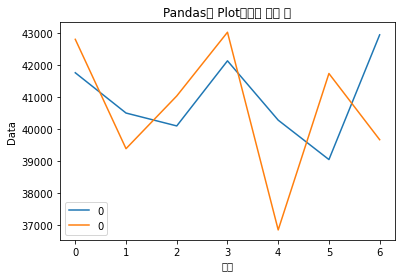

In [243]:
a_0=pd.DataFrame(actual_values_)[0:1][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[0:1][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")
plt.show()

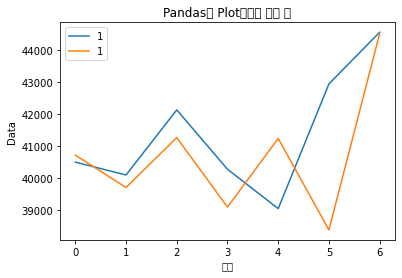

In [244]:
a_0=pd.DataFrame(actual_values_)[1:2][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[1:2][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")
plt.show()

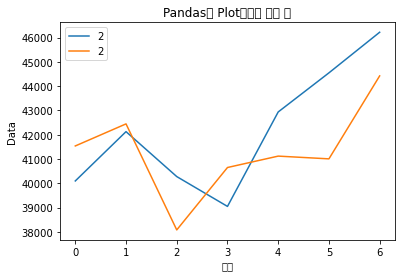

In [245]:
a_0=pd.DataFrame(actual_values_)[2:3][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[2:3][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")
plt.show()

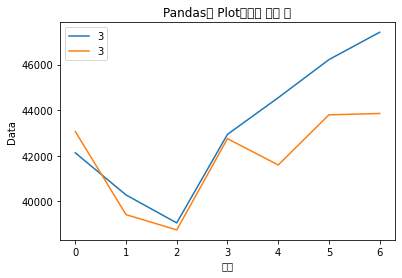

In [246]:
a_0=pd.DataFrame(actual_values_)[3:4][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[3:4][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")
plt.show()

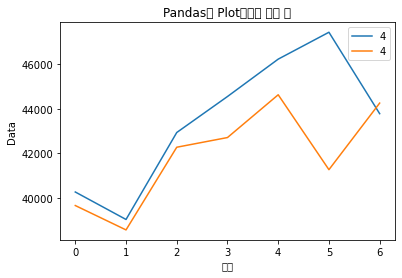

In [247]:
a_0=pd.DataFrame(actual_values_)[4:5][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[4:5][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")
plt.show()

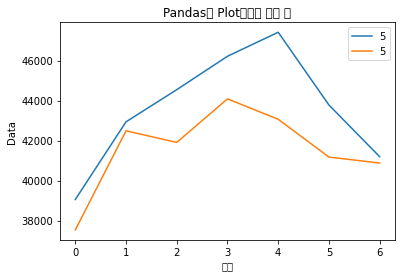

In [248]:
a_0=pd.DataFrame(actual_values_)[5:6][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[5:6][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")
plt.show()

Text(0, 0.5, 'Data')

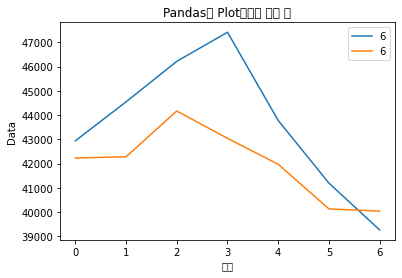

In [249]:
a_0=pd.DataFrame(actual_values_)[6:7][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[6:7][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")

Text(0, 0.5, 'Data')

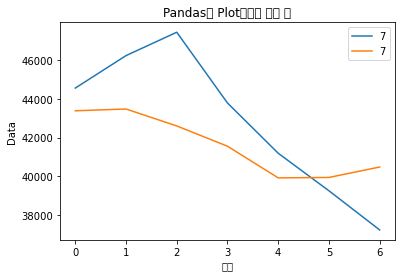

In [250]:
a_0=pd.DataFrame(actual_values_)[7:8][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[7:8][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")

Text(0, 0.5, 'Data')

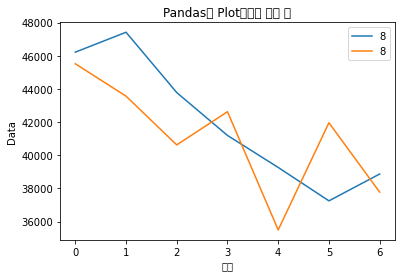

In [251]:
a_0=pd.DataFrame(actual_values_)[8:9][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[8:9][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")

Text(0, 0.5, 'Data')

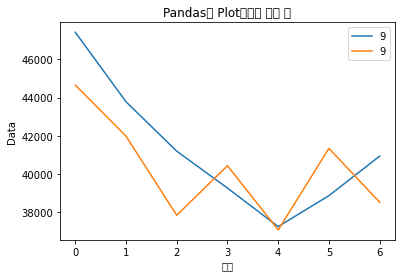

In [252]:
a_0=pd.DataFrame(actual_values_)[9:10][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[9:10][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")

Text(0, 0.5, 'Data')

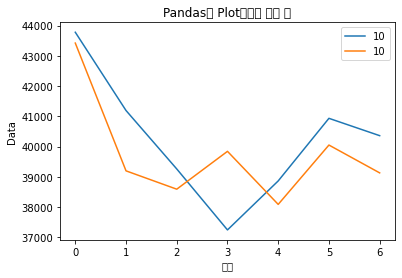

In [253]:
a_0=pd.DataFrame(actual_values_)[10:11][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[10:11][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")

Text(0, 0.5, 'Data')

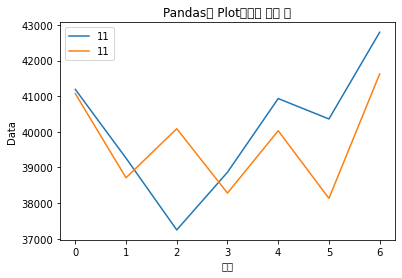

In [254]:
a_0=pd.DataFrame(actual_values_)[11:12][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[11:12][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")

Text(0, 0.5, 'Data')

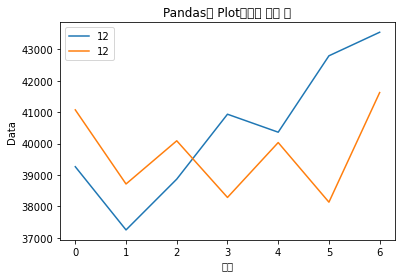

In [255]:
a_0=pd.DataFrame(actual_values_)[12:13][:7].squeeze()
p_0=pd.DataFrame(predicted_vlaues_)[12:13][:7].squeeze()
df_0=pd.concat([a_0,p_0], axis=1)
df_0.plot()
plt.title("Pandas의 Plot메소드 사용 예")
plt.xlabel("시간")
plt.ylabel("Data")